https://github.com/pysal/mgwr/pull/56

In [3]:
import sys
sys.path.append("C:/Users/msachde1/Downloads/Research/Development/mgwr")

In [4]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

from mgwr.gwr import GWR
from spglm.family import Gaussian, Binomial, Poisson
from mgwr.gwr import MGWR
from mgwr.sel_bw import Sel_BW
import multiprocessing as mp
pool = mp.Pool()
from scipy import linalg
import numpy.linalg as la
from scipy import sparse as sp
from scipy.sparse import linalg as spla
from spreg.utils import spdot, spmultiply
from scipy import special
import libpysal as ps
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import copy
from collections import namedtuple
import spglm

#### Fundamental equation

By simple algebraic manipulation, the probability that Y=1 is:

\begin{align}
p = 1 / (1 + exp (-{\beta} & _k x _{k,i})  )            \\
\end{align}

### Approaches tried:

1. Changing XB to : `1 / (1 + np.exp (-1*np.sum(np.multiply(X,params),axis=1)))` - these are the predicted probabilities ~(0,1)


2. Changing XB as above and writing a function to create temp_y as a binary variable using condition `1 if BXi > 0 else 0.`


3. Derived manipulations to temp_y as in iwls for Logistic regression as below:

    `v = np.sum(np.multiply(X,params),axis=1)`
    
    `mu = 1/(1+(np.exp(-v)))`
    
    `z = v + (1/(mu * (1-mu)) * (y-mu))`  -- this becomes the temp_y
    
    Then a simple linear regression can be run as z as the temp dependent variable
    
    
4. Taken from GAM logistic model literature:
   
    `y=exp(b0+b1*x1+...+bm*xm)/{1+exp(b0+b1*x1+...+bm*xm)}`

    Applying the logistic link function to the probability p (ranging between 0  and 1):

    `p' = log {p/(1-p)}`

    By applying the logistic link function, we can now rewrite the model as:

    `p' = b0 + b1*X1  + ... + bm*Xm`

    Finally, we substitute the simple single-parameter additive terms to derive the generalized additive logistic model:

    `p' = b0 + f1(X1) + ... + fm(Xm)`
    
    (http://www.statsoft.com/textbook/generalized-additive-models#gam)
    
    This is the current approach in the latest commit:
    
    `XB = 1 / (1 + np.exp (-1*(np.multiply(X,params))))`
    
    XB is now the probability and is normally distributed
    
    Run MGWR (Gaussian) on this as the dependent variable for the partial models.
    

### Data

#### Clearwater data - downloaded from link: https://sgsup.asu.edu/sparc/multiscale-gwr

In [5]:
data_p = pd.read_csv("C:/Users/msachde1/Downloads/logistic_mgwr_data/landslides.csv") 

In [6]:
data_p.head()

,UserID,X,Y,Elev,Slope,SinAspct,CosAspct,AbsSouth,Landslid,DistStrm
0,1,616168.5625,5201076.5,1450.475,27.44172,0.409126,-0.912478,24.1499,1,8.506
1,2,624923.8125,5201008.5,1567.476,21.88343,-0.919245,-0.393685,66.8160,1,15.561
2,3,615672.0000,5199187.5,1515.065,38.81030,-0.535024,-0.844837,32.3455,1,41.238
3,4,615209.3125,5199112.0,1459.827,26.71631,-0.828548,-0.559918,55.9499,1,17.539
4,5,616354.6875,5198945.5,1379.442,27.55271,-0.872281,-0.489005,60.7248,1,35.023


#### Helper functions - hardcoded here for simplicity in the notebook workflow
Please note: A separate bw_func_b will not be required when changes will be made in the repository

In [7]:
kernel='bisquare'
fixed=False
spherical=False
search_method='golden_section'
criterion='AICc'
interval=None
tol=1e-06
max_iter=500
X_glob=[]

In [8]:
def gwr_func(y, X, bw,family=Gaussian(),offset=None):
    return GWR(coords, y, X, bw, family,offset,kernel=kernel,
               fixed=fixed, constant=False,
               spherical=spherical, hat_matrix=False).fit(
                   lite=True, pool=pool)

def gwr_func_g(y, X, bw):
    return GWR(coords, y, X, bw, family=Gaussian(),offset=None,kernel=kernel,
               fixed=fixed, constant=False,
               spherical=spherical, hat_matrix=False).fit(
                   lite=True, pool=pool)


def bw_func_b(coords,y, X):
    selector = Sel_BW(coords,y, X,family=Binomial(),offset=None, X_glob=[],
                      kernel=kernel, fixed=fixed,
                      constant=False, spherical=spherical)
    return selector

def bw_func_p(coords,y, X):
    selector = Sel_BW(coords,y, X,family=Poisson(),offset=off, X_glob=[],
                      kernel=kernel, fixed=fixed,
                      constant=False, spherical=spherical)
    return selector

def bw_func(coords,y,X):
    selector = Sel_BW(coords,y,X,X_glob=[],
                      kernel=kernel, fixed=fixed,
                      constant=False, spherical=spherical)
    return selector

def sel_func(bw_func, bw_min=None, bw_max=None):
    return bw_func.search(
        search_method=search_method, criterion=criterion,
        bw_min=bw_min, bw_max=bw_max, interval=interval, tol=tol,
        max_iter=max_iter, pool=pool, verbose=False)

### GWR Binomial model with independent variable, x = slope

In [9]:
coords = list(zip(data_p['X'],data_p['Y']))
y = np.array(data_p['Landslid']).reshape((-1,1)) 
elev = np.array(data_p['Elev']).reshape((-1,1))
slope = np.array(data_p['Slope']).reshape((-1,1))
SinAspct = np.array(data_p['SinAspct']).reshape(-1,1)
CosAspct = np.array(data_p['CosAspct']).reshape(-1,1)
X = np.hstack([elev,slope,SinAspct,CosAspct])
x = SinAspct

X_std = (X-X.mean(axis=0))/X.std(axis=0)
x_std = (x-x.mean(axis=0))/x.std(axis=0)
y_std = (y-y.mean(axis=0))/y.std(axis=0)

In [10]:
bw_gwbr=Sel_BW(coords,y,x_std,family=Binomial(),constant=False).search()

In [11]:
gwbr_model=GWR(coords,y,x_std,bw=bw_gwbr,family=Binomial(),constant=False).fit()

In [12]:
bw_gwbr

100.0

In [25]:
predy = 1/(1+np.exp(-1*np.sum(gwbr_model.X * gwbr_model.params, axis=1).reshape(-1, 1)))

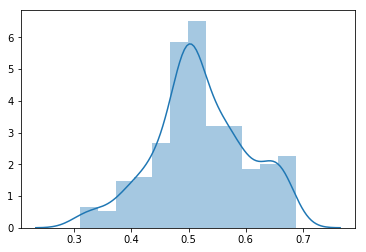

In [26]:
sns.distplot(predy)

In [28]:
(predy==gwbr_model.predy).all()

True

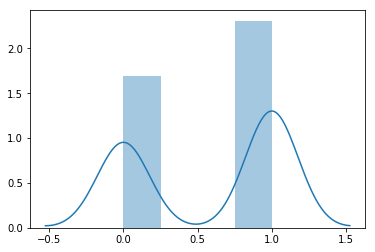

In [29]:
sns.distplot(gwbr_model.y)

#### Multi_bw changes

In [18]:
def multi_bw(init,coords,y, X, n, k, family=Gaussian(),offset=None, tol=1e-06, max_iter=20, multi_bw_min=[None], multi_bw_max=[None],rss_score=True,bws_same_times=3,
                     verbose=True):


    if multi_bw_min==[None]:
        multi_bw_min = multi_bw_min*X.shape[1]
    
    if multi_bw_max==[None]:
        multi_bw_max = multi_bw_max*X.shape[1]
        
    if isinstance(family,spglm.family.Poisson):
        bw = sel_func(bw_func_p(coords,y,X))
        optim_model=gwr_func(y,X,bw,family=Poisson(),offset=offset)
        err = optim_model.resid_response.reshape((-1, 1))
        param = optim_model.params
        #This change for the Poisson model follows from equation (1) above
        XB = offset*np.exp(np.multiply(param, X))
        
    
    elif isinstance(family,spglm.family.Binomial):
        bw = sel_func(bw_func_b(coords,y,X))
        optim_model=gwr_func(y,X,bw,family=Binomial())
        err = optim_model.resid_response.reshape((-1, 1))
        param = optim_model.params
        XB = 1/(1+np.exp(-1*np.multiply(optim_model.params,X)))
        print("first family: "+str(optim_model.family))
        
    else:
        bw=sel_func(bw_func(coords,y,X))
        optim_model=gwr_func(y,X,bw)
        err = optim_model.resid_response.reshape((-1, 1))
        param = optim_model.params
        XB = np.multiply(param, X)
        
    bw_gwr = bw
    XB=XB
    
    if rss_score:
        rss = np.sum((err)**2)
    iters = 0
    scores = []
    delta = 1e6
    BWs = []
    bw_stable_counter = np.ones(k)
    bws = np.empty(k)

    try:
        from tqdm.auto import tqdm  #if they have it, let users have a progress bar
    except ImportError:

        def tqdm(x, desc=''):  #otherwise, just passthrough the range
            return x

    for iters in tqdm(range(1, max_iter + 1), desc='Backfitting'):
        new_XB = np.zeros_like(X)
        neww_XB = np.zeros_like(X)

        params = np.zeros_like(X)

        for j in range(k):
            temp_y = XB[:, j].reshape((-1, 1))
            temp_y = temp_y + err
            
            temp_X = X[:, j].reshape((-1, 1))
            
            #The step below will not be necessary once the bw_func is changed in the repo to accept family and offset as attributes
            if isinstance(family,spglm.family.Poisson):

                bw_class = bw_func_p(coords,temp_y, temp_X)
                
            else:
                bw_class = bw_func(coords,temp_y, temp_X)
                print(bw_class.family)

            if np.all(bw_stable_counter == bws_same_times):
                #If in backfitting, all bws not changing in bws_same_times (default 3) iterations
                bw = bws[j]
            else:
                bw = sel_func(bw_class, multi_bw_min[j], multi_bw_max[j])
                if bw == bws[j]:
                    bw_stable_counter[j] += 1
                else:
                    bw_stable_counter = np.ones(k)

            optim_model = gwr_func_g(temp_y, temp_X, bw)
            print(optim_model.family)
            
            err = optim_model.resid_response.reshape((-1, 1))
            param = optim_model.params.reshape((-1, ))

            new_XB[:,j]=optim_model.predy.reshape(-1)
            params[:, j] = param
            bws[j] = bw

        num = np.sum((new_XB - XB)**2) / n
        print("num = "+str(num))
        den = np.sum(np.sum(new_XB, axis=1)**2)
        score = (num / den)**0.5
        print(score)
        XB = new_XB

        if rss_score:
            print("here")
            predy = 1/(1+np.exp(-1*np.sum(X * params, axis=1).reshape(-1, 1)))
            new_rss = np.sum((y - predy)**2)
            score = np.abs((new_rss - rss) / new_rss)
            rss = new_rss
        scores.append(deepcopy(score))
        delta = score
        print(delta)
        BWs.append(deepcopy(bws))

        if verbose:
            print("Current iteration:", iters, ",SOC:", np.round(score, 7))
            print("Bandwidths:", ', '.join([str(bw) for bw in bws]))

        if delta < tol:
            break
            
    print("iters = "+str(iters))
    opt_bws = BWs[-1]
    print("opt_bws = "+str(opt_bws))
    print(bw_gwr)
    return (opt_bws, np.array(BWs), np.array(scores), params, err, bw_gwr)

In [21]:
mgwbr = multi_bw(init=None,coords=coords,y=y, X=x_std, n=239, k=x.shape[1], family=Binomial())

first family: <spglm.family.Binomial object at 0x0000017B8F302588>
num = 0.2261860620412264
0.1493438159109546
here
0.019261197296944955
Current iteration: 1 ,SOC: 0.0192612
Bandwidths: 82.0
num = 0.0
0.0
here
0.0
Current iteration: 2 ,SOC: 0.0
Bandwidths: 82.0
iters = 2
opt_bws = [82.]
100.0


In [22]:
param = mgwbr[3]

In [23]:
predy = 1/(1+np.exp(-1*np.sum(x_std * param, axis=1).reshape(-1, 1)))

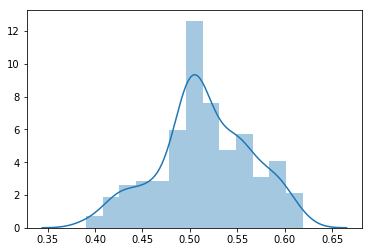

In [24]:
sns.distplot(predy)